**Predicting Airline Delays**<br>
  
Team: Jimmy Nguyen, Maha Jayapal, Roberto Cancel<br>

In [1]:
!pip install --upgrade numpy #ensure numpy and pandas are upgraded to same versions for easier exploration (avoiding errors)
!pip install --upgrade pandas #ensure numpy and pandas are upgraded to same versions for easier exploration (avoiding errors)

# IMPORT LIBRARIES REQUIRED THROUGHOUT THE NOTEBOOK
import boto3 # AWS SDK for Python
import pandas as pd # for importing and manipulating data
import numpy as np
import io # for encoding issues with raw data sets

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrad

In [2]:
# IDENTIFY FILES IN S3 BUCKET
session = boto3.Session()

#Then use the session to get the resource
s3 = session.resource('s3')

my_bucket = s3.Bucket('ads-508-airline')

for my_bucket_object in my_bucket.objects.all():
    print(my_bucket_object.key)


merged/
merged/Dec_merged.csv
raw/
raw/B43_AIRCRAFT_INVENTORY.csv
raw/CARRIER_DECODE.csv
raw/ONTIME_REPORTING_12.csv
raw/P10_EMPLOYEES.csv
raw/airport_weather_dec_2019.csv
raw/airports_list.csv
transformed/
transformed/B43_AIRCRAFT_INVENTORY.csv
transformed/CARRIER_DECODE.csv
transformed/ON_TIME_REPORTING_12.csv
transformed/P10_EMPLOYEES.csv
transformed/airport_weather_dec_2019.csv
transformed/airports_list.csv


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
INGEST DATA SETS<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>

In [3]:
# INGEST FLIGHT DATA

s3_client = boto3.client("s3")

BUCKET='ads-508-airline'
KEY='transformed/ON_TIME_REPORTING_12.csv'

response = s3_client.get_object(Bucket=BUCKET, Key=KEY)
dec_flight = pd.read_csv(response.get("Body"))
dec_flight.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,DEST,DEP_DEL15,DEP_TIME_BLK,ARR_TIME_BLK,CANCELLED,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,8,7,WN,N8651A,15016,STL,SAN,0.0,1100-1159,1300-1359,0.0,245.0,1557.0,7,0.0,0.0,18.0,0.0,0.0
1,8,7,WN,N939WN,15016,STL,SAT,0.0,1200-1259,1400-1459,0.0,145.0,786.0,4,NaN,NaN,NaN,NaN,NaN
2,8,7,WN,N7741C,15016,STL,SAT,0.0,2100-2159,0001-0559,0.0,140.0,786.0,4,NaN,NaN,NaN,NaN,NaN
3,8,7,WN,N550WN,15016,STL,SEA,0.0,0900-0959,1200-1259,0.0,275.0,1709.0,7,NaN,NaN,NaN,NaN,NaN
4,8,7,WN,N8319F,15016,STL,SFO,1.0,1800-1859,2000-2059,0.0,270.0,1735.0,7,NaN,NaN,NaN,NaN,NaN


In [4]:
# INGEST AIRCRAFT DATA - raw data that requires encoding='latin1'

KEY='transformed/B43_AIRCRAFT_INVENTORY.csv'

response = s3_client.get_object(Bucket=BUCKET, Key=KEY)
s3_data = io.BytesIO(response.get('Body').read())
aircraft = pd.read_csv(s3_data, encoding='latin1')
aircraft.head()

,MANUFACTURE_YEAR,TAIL_NUM,NUMBER_OF_SEATS
0,1944,N54514,0.0
1,1945,N1651M,0.0
2,1953,N100CE,0.0
3,1953,N141FL,0.0
4,1953,N151FL,0.0


In [5]:
# INGEST CARRIER NAMES DICTIONARY

KEY='transformed/CARRIER_DECODE.csv'

response = s3_client.get_object(Bucket=BUCKET, Key=KEY)
names = pd.read_csv(response.get("Body"))
names.head()


,AIRLINE_ID,OP_UNIQUE_CARRIER,CARRIER_NAME
0,21754,2PQ,21 Air LLC
1,20342,Q5,40-Mile Air
2,20342,WRB,40-Mile Air
3,19627,CIQ,A/S Conair
4,19072,AAE,AAA Airlines


In [6]:
# INGEST CARRIER EMPLOYEE / STAFFING DATA

KEY='transformed/P10_EMPLOYEES.csv'

response = s3_client.get_object(Bucket=BUCKET, Key=KEY)
employees = pd.read_csv(response.get("Body"))
employees.head()

,OP_UNIQUE_CARRIER,PILOTS_COPILOTS,PASSENGER_HANDLING,PASS_GEN_SVC_ADMIN,MAINTENANCE
0,0WQ,53,0,19,29
1,2HQ,32,0,24,32
2,3EQ,29,0,32,2
3,5V,54,0,0,104
4,5X,1882,0,0,1383


In [7]:
# INGEST DECEMBER 2019 DAILY WEATHER OBSERVATIONS

KEY='transformed/airport_weather_dec_2019.csv'

response = s3_client.get_object(Bucket=BUCKET, Key=KEY)
weather_report = pd.read_csv(response.get("Body"))
weather_report.head()

,DATE,NAME,PRCP,SNOW,SNWD,TMAX,AWND
0,12/1/2019,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,0.04,0.0,0.0,67.0,16.11
1,12/2/2019,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,0.00,0.0,0.0,48.0,16.78
2,12/3/2019,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,0.00,0.0,0.0,49.0,11.18
3,12/4/2019,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,0.00,0.0,0.0,60.0,11.18
4,12/5/2019,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,0.00,0.0,0.0,65.0,5.82


In [8]:
# INGEST CITY AND AIRPORT NAME DICTIONARY

KEY='transformed/airports_list.csv'

response = s3_client.get_object(Bucket=BUCKET, Key=KEY)
cities = pd.read_csv(response.get("Body"))
cities.head()

,ORIGIN_AIRPORT_ID,DISPLAY_AIRPORT_NAME,ORIGIN_CITY_NAME,NAME
0,12992,Adams Field,"Little Rock, AR","NORTH LITTLE ROCK AIRPORT, AR US"
1,10257,Albany International,"Albany, NY","ALBANY INTERNATIONAL AIRPORT, NY US"
2,10140,Albuquerque International Sunport,"Albuquerque, NM","ALBUQUERQUE INTERNATIONAL AIRPORT, NM US"
3,10299,Anchorage International,"Anchorage, AK","ANCHORAGE TED STEVENS INTERNATIONAL AIRPORT, A..."
4,10397,Atlanta Municipal,"Atlanta, GA",ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
DESCRIBE DEC_FLIGHT DATA<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>

In [9]:
# DESCRIBE SHAPE
dec_flight.shape

(625763, 19)

In [10]:
# DESCRIBE FEATURE TYPES (object = categorical string features)
dec_flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625763 entries, 0 to 625762
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   DAY_OF_MONTH         625763 non-null  int64  
 1   DAY_OF_WEEK          625763 non-null  int64  
 2   OP_UNIQUE_CARRIER    625763 non-null  object 
 3   TAIL_NUM             625306 non-null  object 
 4   ORIGIN_AIRPORT_ID    625763 non-null  int64  
 5   ORIGIN               625763 non-null  object 
 6   DEST                 625763 non-null  object 
 7   DEP_DEL15            620253 non-null  float64
 8   DEP_TIME_BLK         625763 non-null  object 
 9   ARR_TIME_BLK         625763 non-null  object 
 10  CANCELLED            625763 non-null  float64
 11  CRS_ELAPSED_TIME     625763 non-null  float64
 12  DISTANCE             625763 non-null  float64
 13  DISTANCE_GROUP       625763 non-null  int64  
 14  CARRIER_DELAY        126945 non-null  float64
 15  WEATHER_DELAY    

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
**DEC_FLIGHT FEATURES: NAME, DESCRIPTION, DROP RATIONALE (IF APPROPRIATE)**<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
DAY_OF_MONTH - Day of the Month  <br>
DAY_OF_WEEK - Day of the Week  - 1= MON, 2=TUES, 3=WED, 4=THUR, 5=FRI, 6=SAT, 7=SUN, 9=UNKNOWN    <br>
OP_UNIQUE_CARRIER - Unique Carrier Code (ID) - NEEDED TO MERGE WITH EMPLOYEES AND NAMES <br>
TAIL_NUM - Aircraft Tail # (ID)  - NEEDED TO MERGE WITH AIRCRAFT <br>
ORIGIN - Departure Airport ID (LINKS TO WEATHER STATIONS)  <br>
DEST - Arrival Airport ID (LINKS TO WEATHER STATIONS)  <br>
DEP_DEL15 - Departure Delay Indicator, 15 minutes or more(1=YES) - **TARGET FEATURE**  <br>
DEP_TIME_BLK - Scheduled Departure Time block, Hourly interval  <br>
ARR_TIME_BLK - Scheduled Arrival Time Block, HOURLY INTERVALS  <br>
CANCELLED - Cancelled Flight Indicator (1=YES)  <br>
CRS_ELAPSED_TIME - Scheduled Elapsed Time  <br>
DISTANCE - Distance Traveled in Miles <br>
DISTANCE_GROUP - Distance Traveled block in increments of 250 miles (1 < 250, 2 = 250-499, ..., 11=2500+ miles <br>
CARRIER_DELAY - Carrier Delay in Minutes <br>
WEATHER_DELAY - Extreme Weather Delay in Minutes  <br>
NAS_DELAY - National Air System Delay in Minutes  <br> 
SECURITY_DELAY - Security Delay in Minutes <br>
LATE_AIRCRAFT_DELAY - Late Arrival Delay in Minutes<br>

In [11]:
# EXPLORE MISSINGNESS OF EACH FEATURE
dec_flight.isna().sum()

DAY_OF_MONTH                0
DAY_OF_WEEK                 0
OP_UNIQUE_CARRIER           0
TAIL_NUM                  457
ORIGIN_AIRPORT_ID           0
ORIGIN                      0
DEST                        0
DEP_DEL15                5510
DEP_TIME_BLK                0
ARR_TIME_BLK                0
CANCELLED                   0
CRS_ELAPSED_TIME            0
DISTANCE                    0
DISTANCE_GROUP              0
CARRIER_DELAY          498818
WEATHER_DELAY          498818
NAS_DELAY              498818
SECURITY_DELAY         498818
LATE_AIRCRAFT_DELAY    498818
dtype: int64

**FEATURE MISSINGNESS NOTES:**<br>

1 - 457 observations with missing Tail Number.<br>
2 - 5510 observations with missing target variables - drop observations in Module 4.<br>
3 - 498,818 observations missing delay flags/minutes delayed info - likely on time departures.<br>

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
**DEC_FLIGHT NUMERIC FEATURES DISTRIBUTION**<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>

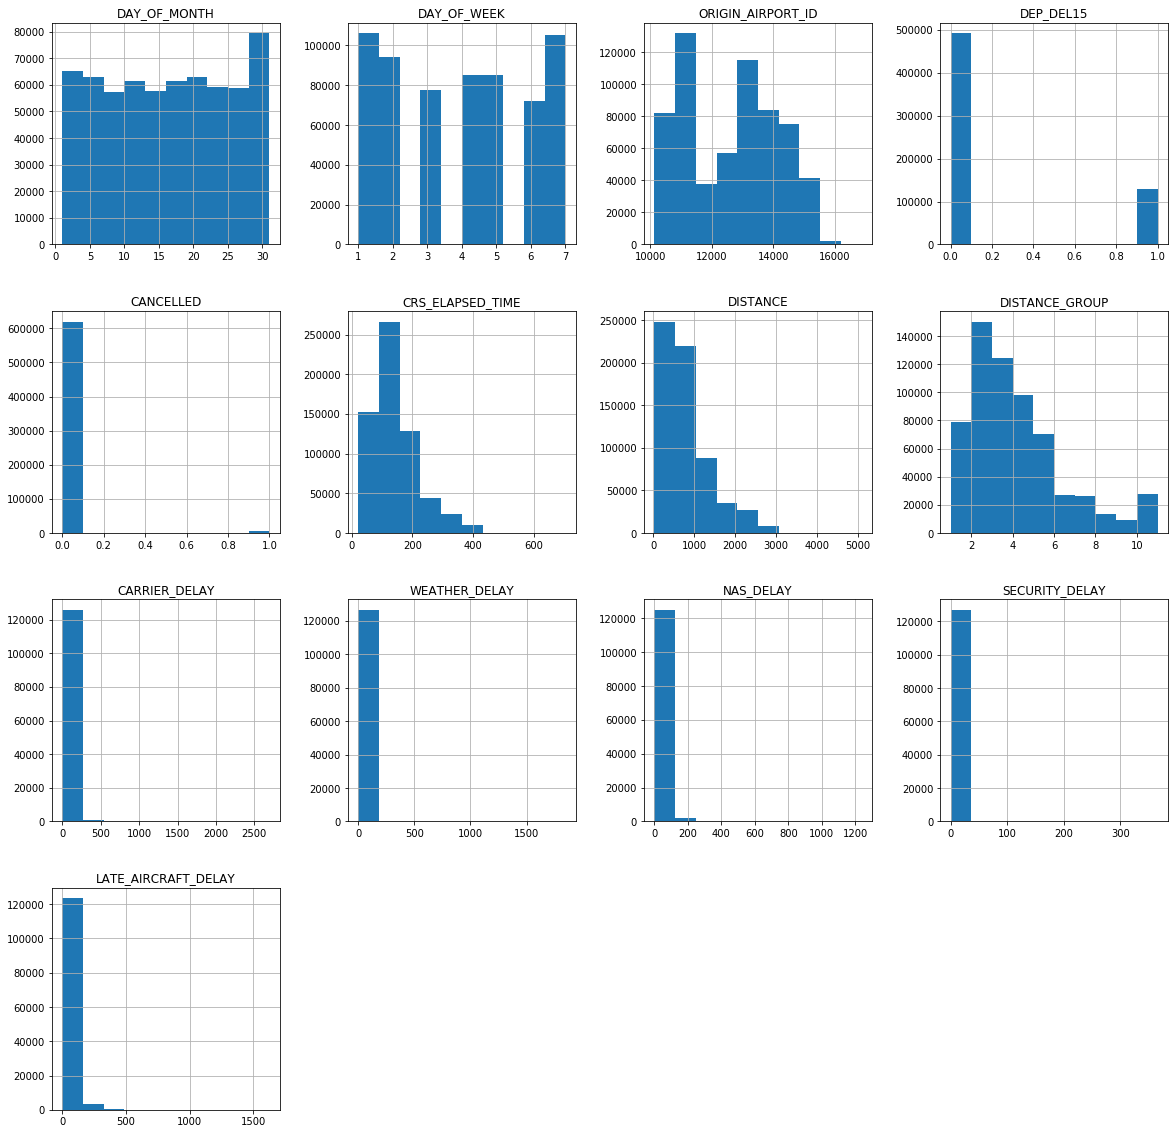

In [12]:
# Graph Distributions of numerical features
histlist = dec_flight.hist(figsize = (20,20))

**Interesting Numeric Feature distribution discussion:** <br> 

Day of Month - Small variations throughout the month with peak on 30th. <br>
Day of Week - Sunday + Monday = Peak | Satuday = low | Tuesday - Friday Variation<br>
Cancelled - Cancelled flights need to be removed b/c delay info is not available - Module 4<br>
CRS (Scheduled) Elapsed time - Right-skewed - most flights are shorter in duration <br>
Distance / Distance Group - VERY right-skewed with almost 50% of flights below 500 miles.<br>
DEP_DELAY15 (Target Variable) - IMBALANCED DATA SET - will need to be balanced before ML <br>
Delay codes disprortionally 0 = no delay - difficult to interpret. <br>

## What days of the month are best and worst for departure delays?

In [13]:
# Explore DAY_OF_MONTH with DEP_DEL15
month = pd.crosstab(dec_flight['DAY_OF_MONTH'], dec_flight['DEP_DEL15'])
month['Total'] = month.sum(axis=1)
month.loc['Total'] = month.sum()
month['Percent_Delayed'] = ((month.iloc[:,1])/((month.iloc[:,0])+(month.iloc[:,1])))
month = month.sort_values('Percent_Delayed')
month

DEP_DEL15,0.0,1.0,Total,Percent_Delayed
DAY_OF_MONTH,,,,
7,14303,1732,16035,0.108014
25,14579,1884,16463,0.114438
8,17762,2459,20221,0.121606
5,18275,2906,21181,0.137198
6,18070,3116,21186,0.147078
10,16760,2909,19669,0.147898
15,17126,3057,20183,0.151464
12,17992,3217,21209,0.151681
24,13902,2769,16671,0.166097


**Summary:**<br>
Days of the month show differences, but no obvious pattern - let's explore day of the week.

## What day of the week is the best and worst for departure delays?

In [14]:
# Explore DAY_OF_WEEK with DEP_DEL15
week = pd.crosstab(dec_flight['DAY_OF_WEEK'], dec_flight['DEP_DEL15'])
week['Total'] = week.sum(axis=1)
week.loc['Total'] = week.sum()
week['Percent_Delayed'] = ((week.iloc[:,1])/((week.iloc[:,0])+(week.iloc[:,1])))
week = week.sort_values('Percent_Delayed')
week

DEP_DEL15,0.0,1.0,Total,Percent_Delayed
DAY_OF_WEEK,,,,
4,69481,15126,84607,0.178780
5,68868,15807,84675,0.186678
3,62131,14977,77108,0.194234
2,74760,18449,93209,0.197932
6,57531,14217,71748,0.198152
Total,492096,128157,620253,0.206621
7,80845,23404,104249,0.224501
1,78480,26177,104657,0.250122


**Summary:**<br>
The best days of the week are 4 (Thursday) @ 17.9% and 5 (Friday) @ 18.7%.<br>
The worst days of the week are 1 (Monday) @ 25% and 7 (Sunday) @ 22.5%.<br>

## What distance groups perform best and worst for departure delays?

In [15]:
# Explore DISTANCE_GROUP with DEP_DEL15
Dist = pd.crosstab(dec_flight['DISTANCE_GROUP'], dec_flight['DEP_DEL15'])
Dist['Total'] = Dist.sum(axis=1)
Dist.loc['Total'] = Dist.sum()
Dist['Percent_Delayed'] = ((Dist.iloc[:,1])/((Dist.iloc[:,0])+(Dist.iloc[:,1])))
Dist = Dist.sort_values('Percent_Delayed')
Dist

DEP_DEL15,0.0,1.0,Total,Percent_Delayed
DISTANCE_GROUP,,,,
1,63452,14152,77604,0.182362
3,98656,24926,123582,0.201696
Total,492096,128157,620253,0.206621
4,77200,20107,97307,0.206635
2,117550,30683,148233,0.206992
6,21412,5642,27054,0.208546
10,12621,3554,16175,0.219722
5,54398,15357,69755,0.220156
7,20416,5856,26272,0.222899


**Summary:*<br>
The best distance groups are 1 (<250 miles) @ 18.2% and 3 (500-749 miles) @ 21.2%.<br>
The worst distance groups are 8 (1750-1999 Miles) @ 23.5% and 11 (>2500 Miles) @ 23.5%.<br>

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
**DEC_FLIGHT OBJECT FEATURES DISTRIBUTION**<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>

In [16]:
# Count the unique values of categorical/object-stored features
dec_flight[['OP_UNIQUE_CARRIER', 'TAIL_NUM', 'ORIGIN', 'DEST','DEP_TIME_BLK', 'ARR_TIME_BLK']].nunique()

OP_UNIQUE_CARRIER      17
TAIL_NUM             5478
ORIGIN                350
DEST                  350
DEP_TIME_BLK           19
ARR_TIME_BLK           19
dtype: int64

**NOTE:**  
High cardinality in Tail_Num, Origin, Dest make analysis difficult.

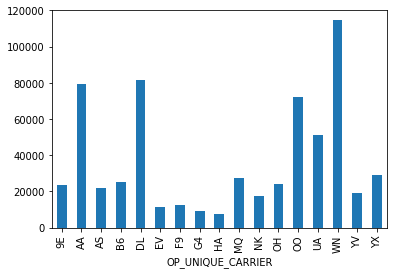

In [17]:
# Carrier Distribution
dec_flight.groupby('OP_UNIQUE_CARRIER').size().plot.bar()

**Note:**<br>
We see a significant variation in the number of flights per carrier. <br>

Of the 17 carriers, AA (American Airlines), DL (Delta Airlines) , OO (Skywest - regional), WN (Southwest), and UA (United Airlines) are the leaders in terms of volume. <br>


## What are the best and worst performing airlines for departure delays?

In [18]:
# Explore OP_UNIQUE_CARRIER with DEP_DEL15
carrier = pd.crosstab(dec_flight['OP_UNIQUE_CARRIER'], dec_flight['DEP_DEL15'])
carrier['Total'] = carrier.sum(axis=1)
carrier.loc['Total'] = carrier.sum()
carrier['Percent_Delayed'] = ((carrier.iloc[:,1])/((carrier.iloc[:,0])+(carrier.iloc[:,1])))
carrier = carrier.sort_values('Percent_Delayed')
print(carrier)

DEP_DEL15             0.0     1.0   Total  Percent_Delayed
OP_UNIQUE_CARRIER                                         
HA                   6618     651    7269         0.089558
DL                  68764   12736   81500         0.156270
9E                  19174    3960   23134         0.171177
AA                  65242   14001   79243         0.176684
MQ                  21869    4877   26746         0.182345
NK                  14064    3146   17210         0.182801
YX                  23081    5263   28344         0.185683
UA                  41276    9889   51165         0.193277
OO                  56526   14016   70542         0.198690
Total              492096  128157  620253         0.206621
OH                  18804    5218   24022         0.217218
EV                   8569    2409   10978         0.219439
AS                  16700    5073   21773         0.232995
YV                  14221    4338   18559         0.233741
G4                   7124    2191    9315         0.2352

**Summary:**<br>
We note a wide range of percent of departures delayed by carrier. This could indicate that carrier-specific data (such as staffing) could be good indicators for predicting delays.<br>

Mean % Delayed departures = 20.7% <br>
Worst performaing carriers = B6 (JetBlue) @ 31.3% and WN (Southwest) @ 26.1%<br>
Best performing carriers = HA (Hawaiian Airlines) @ 9% and DL (Delta Airlines) @ 15.6%<br>

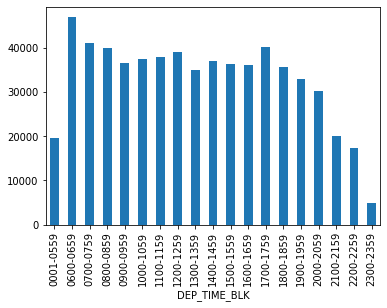

In [19]:
# Departure Time Block distribution
dec_flight.groupby('DEP_TIME_BLK').size().plot.bar()

**Summary:**<br>
Highest number of departures from 6-659am, lowest from 11-1159pm.<br>
Hourly variations exist as well<br>

## What are the best and worst performing time blocks for departure delays?

In [20]:
# Explore DEPT_TIME_BULK with DEP_DEL15
time_block = pd.crosstab(dec_flight['DEP_TIME_BLK'], dec_flight['DEP_DEL15'])
time_block['Total'] = time_block.sum(axis=1)
time_block.loc['Total'] = time_block.sum()
time_block['Percent_Delayed'] = ((time_block.iloc[:,1])/((time_block.iloc[:,0])+(time_block.iloc[:,1])))
time_block = time_block.sort_values('Percent_Delayed')
time_block

DEP_DEL15,0.0,1.0,Total,Percent_Delayed
DEP_TIME_BLK,,,,
0600-0659,42566,3952,46518,0.084956
0001-0559,17565,1964,19529,0.100568
0700-0759,36653,4376,41029,0.106656
0800-0859,34384,5254,39638,0.132550
0900-0959,30593,5706,36299,0.157194
1000-1059,30423,6876,37299,0.184348
1100-1159,30424,7374,37798,0.195090
Total,492096,128157,620253,0.206621
1200-1259,30721,8133,38854,0.209322


**Answer:**<br>
Best times = 6-659am @ 8.5% and 1201am - 6am @ 10%<br>
Worst times = 7-759pm @ 29.9% and 9-959pm @ 29.7%<br>

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
DESCRIBE AIRCRAFT DATA<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>

In [21]:
# DESCRIBE SHAPE
aircraft.shape

(7383, 3)

In [22]:
# DESCRIBE FEATURE TYPES
aircraft.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7383 entries, 0 to 7382
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MANUFACTURE_YEAR  7383 non-null   int64  
 1   TAIL_NUM          7383 non-null   object 
 2   NUMBER_OF_SEATS   7376 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 173.2+ KB


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
AIRCRAFT FEATURES: NAME, DESCRIPTION  
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>

(LIST EACH FEATURE AND DESCRIPTOIN)

In [23]:
# Count the unique values per feature
aircraft.nunique()

MANUFACTURE_YEAR      62
TAIL_NUM            7361
NUMBER_OF_SEATS      121
dtype: int64

In [24]:
# DESCRIBE MISSINGNESS OF FEATURES
aircraft.isna().sum() 

MANUFACTURE_YEAR    0
TAIL_NUM            0
NUMBER_OF_SEATS     7
dtype: int64

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
DESCRIBE NAMES DATA<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>

In [25]:
# DESCRIBE SHAPE
names.shape

(1744, 3)

In [26]:
# DESCRIBE FEATURE TYPES
names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   AIRLINE_ID         1744 non-null   int64 
 1   OP_UNIQUE_CARRIER  1743 non-null   object
 2   CARRIER_NAME       1744 non-null   object
dtypes: int64(1), object(2)
memory usage: 41.0+ KB


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
NAMES FEATURES: NAME, DESCRIPTION<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>

(LIST EACH FEATURE AND DESCRIPTION)

In [27]:
# Count the unique values per feature
names.nunique()

AIRLINE_ID           1597
OP_UNIQUE_CARRIER    1743
CARRIER_NAME         1606
dtype: int64

In [28]:
# DESCRIBE MISSINGNESS OF FEATURES
names.isna().sum() 

AIRLINE_ID           0
OP_UNIQUE_CARRIER    1
CARRIER_NAME         0
dtype: int64

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
DESCRIBE EMPLOYEES DATA<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>

In [29]:
# DESCRIBE SHAPE
employees.shape 

(44, 5)

In [30]:
# DESCRIBE FEATURE TYPES
employees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   OP_UNIQUE_CARRIER   44 non-null     object
 1   PILOTS_COPILOTS     44 non-null     int64 
 2   PASSENGER_HANDLING  44 non-null     int64 
 3   PASS_GEN_SVC_ADMIN  44 non-null     int64 
 4   MAINTENANCE         44 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 1.8+ KB


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
EMPLOYEES FEATURES: NAME, DESCRIPTION<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>

(LIST FEATURES AND DESCRIPTION)

In [31]:
# Count the unique values per feature
employees.nunique()

OP_UNIQUE_CARRIER     44
PILOTS_COPILOTS       42
PASSENGER_HANDLING    17
PASS_GEN_SVC_ADMIN    31
MAINTENANCE           42
dtype: int64

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
EMPLOYEES FEATURES DISTRIBUTION<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>

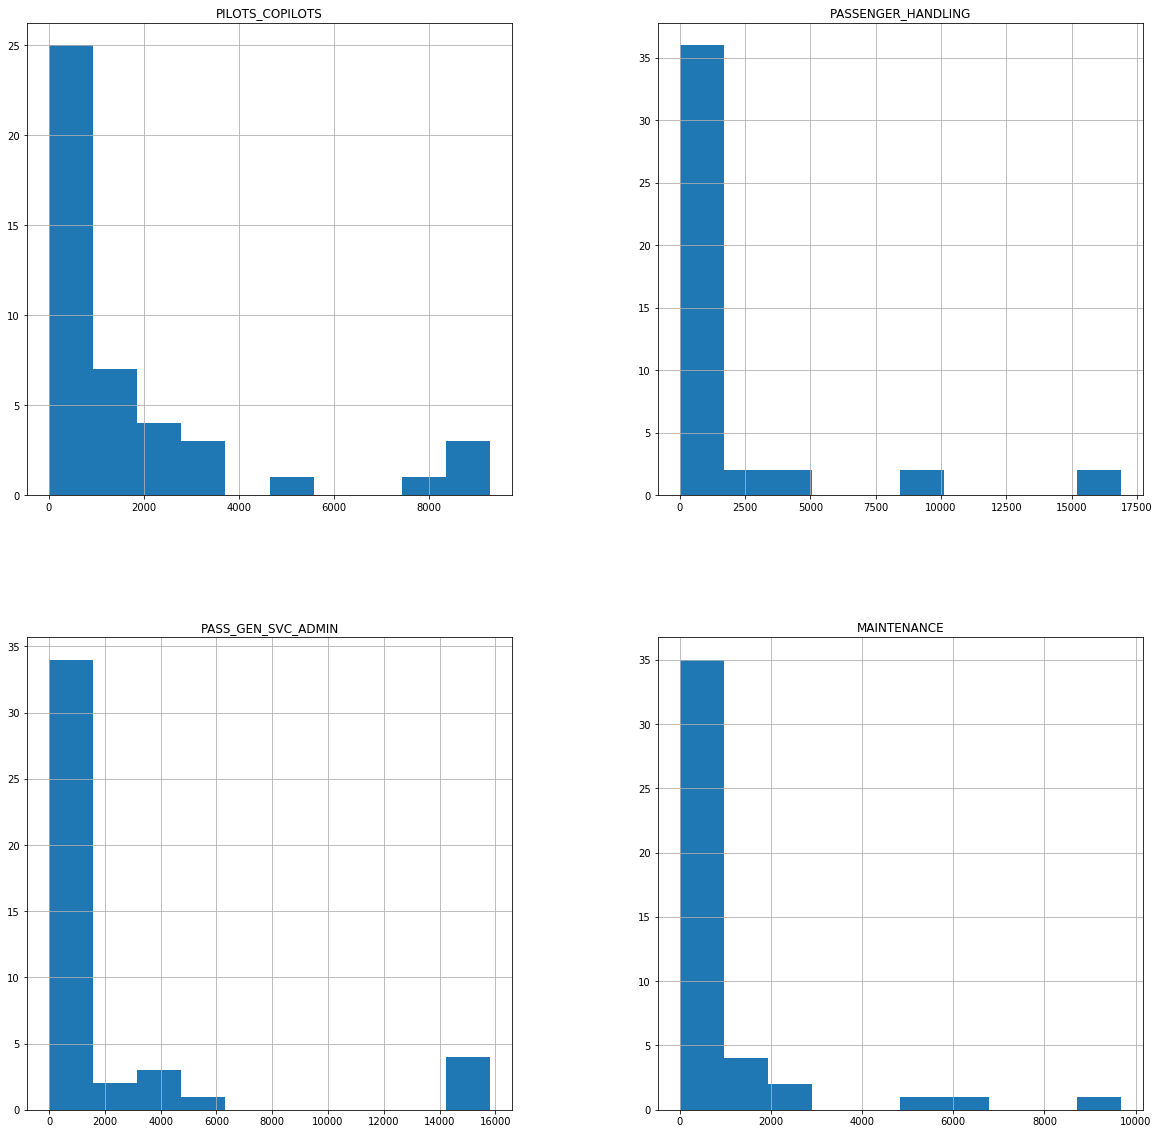

In [32]:
# Graph Distributions of numerical features
histlist3 = employees.hist(figsize = (20, 20))

In [33]:
# DESCRIBE MISSINGNESS OF FEATURES
employees.isna().sum() 

OP_UNIQUE_CARRIER     0
PILOTS_COPILOTS       0
PASSENGER_HANDLING    0
PASS_GEN_SVC_ADMIN    0
MAINTENANCE           0
dtype: int64

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
DESCRIBE WEATHER_REPORT DATA<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>

In [34]:
# DESCRIBE SHAPE
weather_report.shape 

(3286, 7)

In [35]:
# DESCRIBE FEATURE TYPES
weather_report.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    3286 non-null   object 
 1   NAME    3286 non-null   object 
 2   PRCP    3286 non-null   float64
 3   SNOW    2282 non-null   float64
 4   SNWD    2231 non-null   float64
 5   TMAX    3284 non-null   float64
 6   AWND    3255 non-null   float64
dtypes: float64(5), object(2)
memory usage: 179.8+ KB


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
WEATHER_REPORT FEATURES: NAME, DESCRIPTION<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>

(LIST FEATURES AND DESCRIPTION)

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
WEATHER_REPORT FEATURES DISTRIBUTION<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>

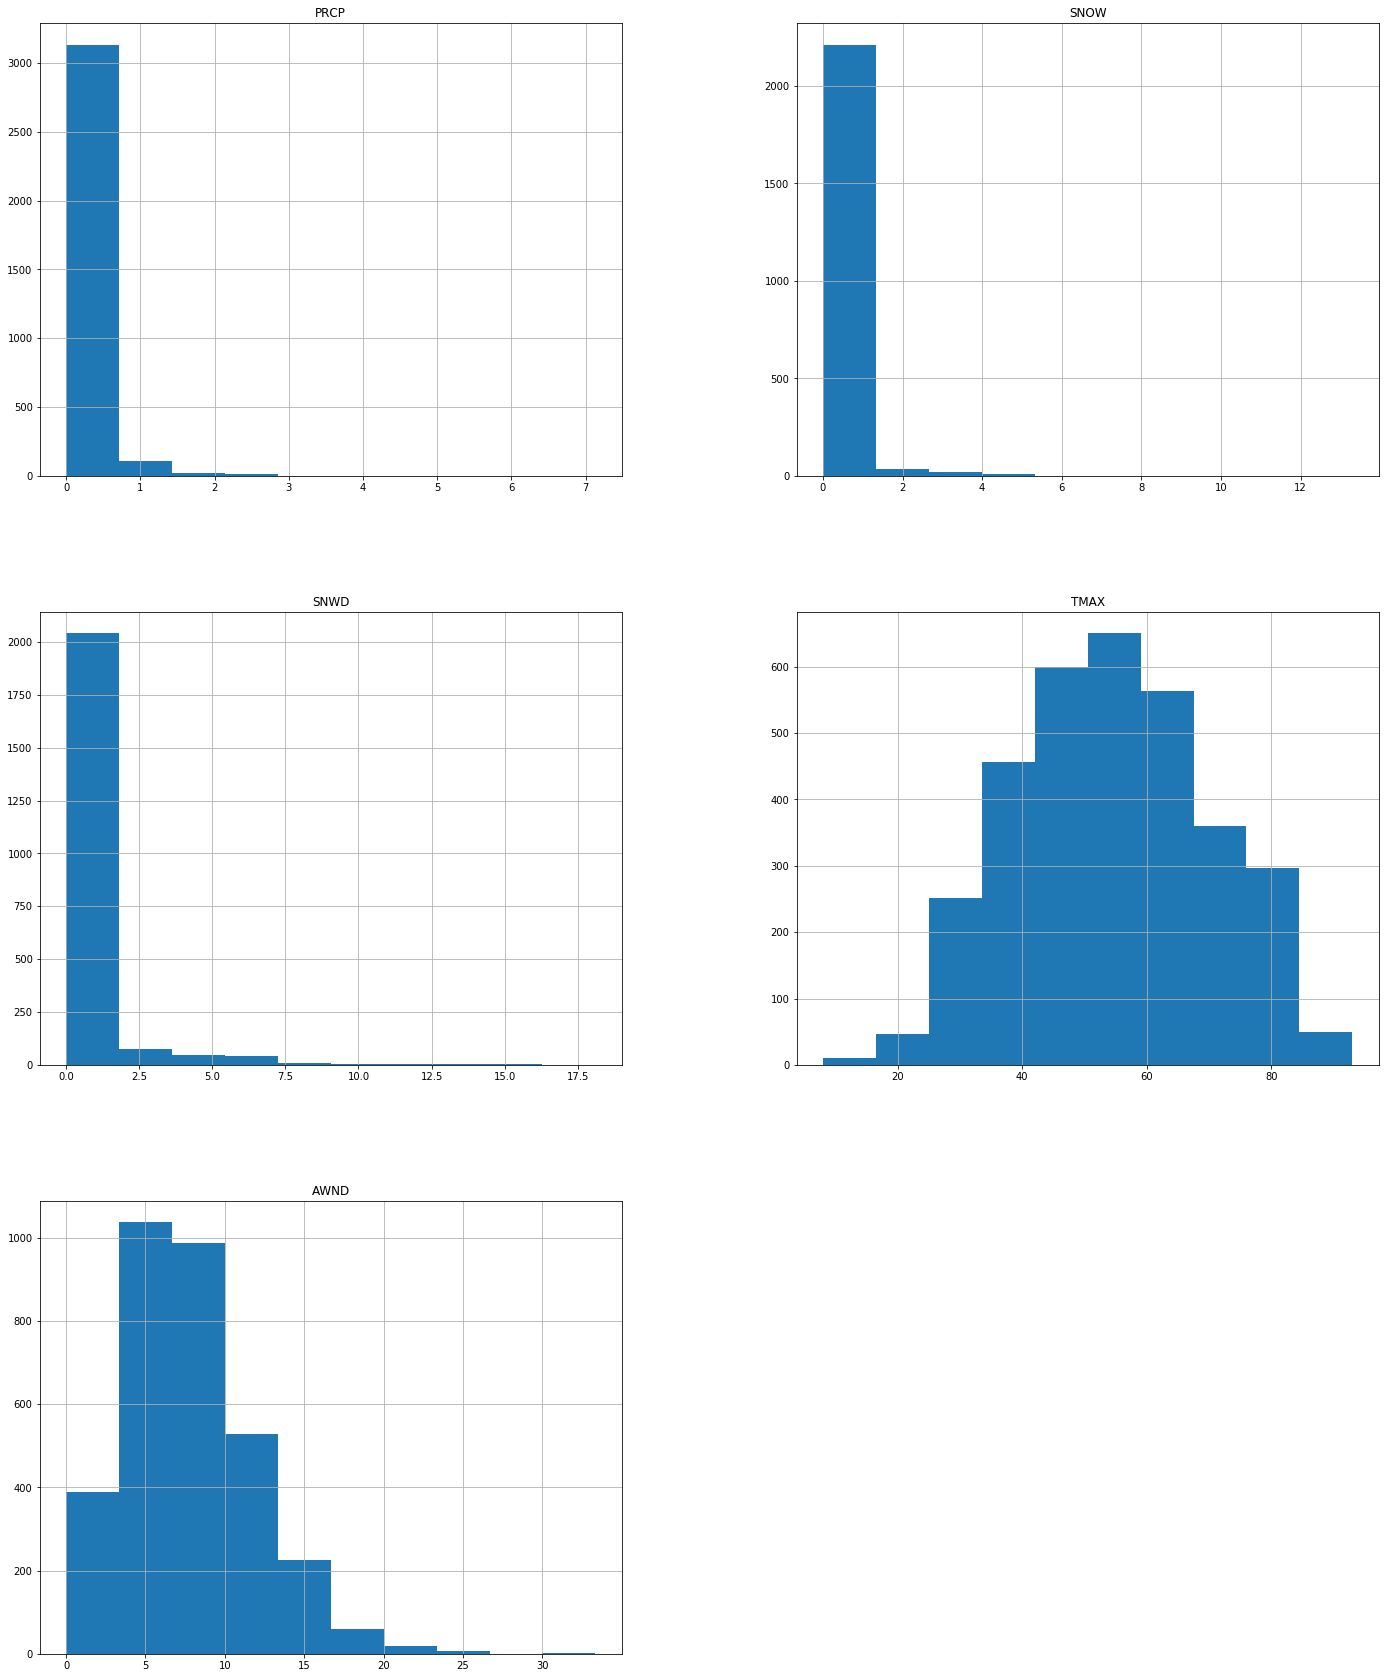

In [36]:
# Graph Distributions of numerical features
histlist3 = weather_report.hist(figsize = (24, 30))

In [37]:
# DESCRIBE MISSINGNESS OF FEATURES
weather_report.isna().sum() 

DATE       0
NAME       0
PRCP       0
SNOW    1004
SNWD    1055
TMAX       2
AWND      31
dtype: int64

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
DESCRIBE CITIES DATA<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>

In [38]:
# DESCRIBE SHAPE
cities.shape 

(97, 4)

In [39]:
# DESCRIBE FEATURE TYPES
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ORIGIN_AIRPORT_ID     97 non-null     int64 
 1   DISPLAY_AIRPORT_NAME  97 non-null     object
 2   ORIGIN_CITY_NAME      97 non-null     object
 3   NAME                  97 non-null     object
dtypes: int64(1), object(3)
memory usage: 3.2+ KB


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
CITIES FEATURES: NAME, DESCRIPTION<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>

(LIST CITY FEATURES AND DESCRIPTIONS)

In [40]:
# Count the unique values per feature
cities.nunique()

ORIGIN_AIRPORT_ID       97
DISPLAY_AIRPORT_NAME    97
ORIGIN_CITY_NAME        94
NAME                    86
dtype: int64

In [41]:
# DESCRIBE MISSINGNESS OF FEATURES
cities.isna().sum() 

ORIGIN_AIRPORT_ID       0
DISPLAY_AIRPORT_NAME    0
ORIGIN_CITY_NAME        0
NAME                    0
dtype: int64

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
CLEAN & MERGE DATA SETS<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>

In [42]:
dec_flight.isna().sum()

DAY_OF_MONTH                0
DAY_OF_WEEK                 0
OP_UNIQUE_CARRIER           0
TAIL_NUM                  457
ORIGIN_AIRPORT_ID           0
ORIGIN                      0
DEST                        0
DEP_DEL15                5510
DEP_TIME_BLK                0
ARR_TIME_BLK                0
CANCELLED                   0
CRS_ELAPSED_TIME            0
DISTANCE                    0
DISTANCE_GROUP              0
CARRIER_DELAY          498818
WEATHER_DELAY          498818
NAS_DELAY              498818
SECURITY_DELAY         498818
LATE_AIRCRAFT_DELAY    498818
dtype: int64

**To discuss  - we're missing more delay flag values than the number of on_time flights - should we just drop these features to retain observations?**

In [43]:
# Drop observations with missing TARGET VARIABLE (dep_del15)
dec_flight.drop(dec_flight.loc[dec_flight['DEP_DEL15'].isna()].index, axis=0, inplace=True)

# Drop cancelled flights
dec_flight.drop(dec_flight[dec_flight['CANCELLED'] == 1].index, inplace = True)

In [44]:
# Drop Duplicates to retain a dictionary
aircraft.drop_duplicates(subset='TAIL_NUM', inplace=True)
aircraft.head()

,MANUFACTURE_YEAR,TAIL_NUM,NUMBER_OF_SEATS
0,1944,N54514,0.0
1,1945,N1651M,0.0
2,1953,N100CE,0.0
3,1953,N141FL,0.0
4,1953,N151FL,0.0


In [45]:
# Drop Duplicates to retain a dictionary
names.drop_duplicates(subset='OP_UNIQUE_CARRIER', inplace=True)
names = names.reset_index(drop=True)
names

,AIRLINE_ID,OP_UNIQUE_CARRIER,CARRIER_NAME
0,21754,2PQ,21 Air LLC
1,20342,Q5,40-Mile Air
2,20342,WRB,40-Mile Air
3,19627,CIQ,A/S Conair
4,19072,AAE,AAA Airlines
...,...,...,...
1739,20379,ZKQ,Zantop International
1740,19771,ZAQ,Zas Airline Of Egypt
1741,21118,37,Zeal 320
1742,22069,ZG,ZIPAIR Tokyo Inc.


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
MERGE WEATHER AND CITIES FLIGHT DATA<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>

In [46]:
# Merge weather report and cities for future merging
weather = pd.merge(cities, weather_report, how='left', on='NAME')
weather.head()

,ORIGIN_AIRPORT_ID,DISPLAY_AIRPORT_NAME,ORIGIN_CITY_NAME,NAME,DATE,PRCP,SNOW,SNWD,TMAX,AWND
0,12992,Adams Field,"Little Rock, AR","NORTH LITTLE ROCK AIRPORT, AR US",12/1/2019,0.00,0.0,0.0,53.0,10.07
1,12992,Adams Field,"Little Rock, AR","NORTH LITTLE ROCK AIRPORT, AR US",12/2/2019,0.00,0.0,0.0,47.0,4.03
2,12992,Adams Field,"Little Rock, AR","NORTH LITTLE ROCK AIRPORT, AR US",12/3/2019,0.00,0.0,0.0,56.0,4.03
3,12992,Adams Field,"Little Rock, AR","NORTH LITTLE ROCK AIRPORT, AR US",12/4/2019,0.00,0.0,0.0,62.0,2.91
4,12992,Adams Field,"Little Rock, AR","NORTH LITTLE ROCK AIRPORT, AR US",12/5/2019,0.01,0.0,0.0,65.0,4.92


In [47]:
# Change date format to match flight data (Month & Day_of_Month)
weather['DATE'] = pd.to_datetime(weather['DATE'])
weather['MONTH'] = pd.DatetimeIndex(weather['DATE']).month
weather['DAY_OF_MONTH'] = pd.DatetimeIndex(weather['DATE']).day
weather

,ORIGIN_AIRPORT_ID,DISPLAY_AIRPORT_NAME,ORIGIN_CITY_NAME,NAME,DATE,PRCP,SNOW,SNWD,TMAX,AWND,MONTH,DAY_OF_MONTH
0,12992,Adams Field,"Little Rock, AR","NORTH LITTLE ROCK AIRPORT, AR US",2019-12-01,0.00,0.0,0.0,53.0,10.07,12.0,1.0
1,12992,Adams Field,"Little Rock, AR","NORTH LITTLE ROCK AIRPORT, AR US",2019-12-02,0.00,0.0,0.0,47.0,4.03,12.0,2.0
2,12992,Adams Field,"Little Rock, AR","NORTH LITTLE ROCK AIRPORT, AR US",2019-12-03,0.00,0.0,0.0,56.0,4.03,12.0,3.0
3,12992,Adams Field,"Little Rock, AR","NORTH LITTLE ROCK AIRPORT, AR US",2019-12-04,0.00,0.0,0.0,62.0,2.91,12.0,4.0
4,12992,Adams Field,"Little Rock, AR","NORTH LITTLE ROCK AIRPORT, AR US",2019-12-05,0.01,0.0,0.0,65.0,4.92,12.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2972,10713,Boise Air Terminal,"Boise, ID","BOISE AIR TERMINAL, ID US",2019-12-27,0.00,0.0,0.0,35.0,5.82,12.0,27.0
2973,10713,Boise Air Terminal,"Boise, ID","BOISE AIR TERMINAL, ID US",2019-12-28,0.00,0.0,0.0,39.0,2.24,12.0,28.0
2974,10713,Boise Air Terminal,"Boise, ID","BOISE AIR TERMINAL, ID US",2019-12-29,0.04,0.1,0.0,32.0,6.26,12.0,29.0
2975,10713,Boise Air Terminal,"Boise, ID","BOISE AIR TERMINAL, ID US",2019-12-30,0.00,0.0,0.0,34.0,2.46,12.0,30.0


In [48]:
# Merge aircraft information into flight data file
Dec_flight = pd.merge(dec_flight, aircraft, how="left", on='TAIL_NUM')

In [49]:
# Merge names and flight data for consistent airline names
Dec_flight2 = pd.merge(Dec_flight, names, how='left', on=['OP_UNIQUE_CARRIER'])

In [50]:
# Merge Employee
Dec_flight3 = pd.merge(Dec_flight2, employees, how='left', on=['OP_UNIQUE_CARRIER'])

In [51]:
Dec_flight3.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,DEST,DEP_DEL15,DEP_TIME_BLK,ARR_TIME_BLK,...,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,MANUFACTURE_YEAR,NUMBER_OF_SEATS,AIRLINE_ID,CARRIER_NAME,PILOTS_COPILOTS,PASSENGER_HANDLING,PASS_GEN_SVC_ADMIN,MAINTENANCE
0,8,7,WN,N8651A,15016,STL,SAN,0.0,1100-1159,1300-1359,...,0.0,0.0,2014.0,175.0,19393,Southwest Airlines Co.,8989,9668,15475,2482
1,8,7,WN,N939WN,15016,STL,SAT,0.0,1200-1259,1400-1459,...,NaN,NaN,2009.0,143.0,19393,Southwest Airlines Co.,8989,9668,15475,2482
2,8,7,WN,N7741C,15016,STL,SAT,0.0,2100-2159,0001-0559,...,NaN,NaN,2007.0,143.0,19393,Southwest Airlines Co.,8989,9668,15475,2482
3,8,7,WN,N550WN,15016,STL,SEA,0.0,0900-0959,1200-1259,...,NaN,NaN,2001.0,143.0,19393,Southwest Airlines Co.,8989,9668,15475,2482
4,8,7,WN,N8319F,15016,STL,SFO,1.0,1800-1859,2000-2059,...,NaN,NaN,2012.0,175.0,19393,Southwest Airlines Co.,8989,9668,15475,2482


In [52]:
Dec_flight3.isna().sum()

DAY_OF_MONTH                0
DAY_OF_WEEK                 0
OP_UNIQUE_CARRIER           0
TAIL_NUM                    0
ORIGIN_AIRPORT_ID           0
ORIGIN                      0
DEST                        0
DEP_DEL15                   0
DEP_TIME_BLK                0
ARR_TIME_BLK                0
CANCELLED                   0
CRS_ELAPSED_TIME            0
DISTANCE                    0
DISTANCE_GROUP              0
CARRIER_DELAY          493025
WEATHER_DELAY          493025
NAS_DELAY              493025
SECURITY_DELAY         493025
LATE_AIRCRAFT_DELAY    493025
MANUFACTURE_YEAR        23498
NUMBER_OF_SEATS         23498
AIRLINE_ID                  0
CARRIER_NAME                0
PILOTS_COPILOTS             0
PASSENGER_HANDLING          0
PASS_GEN_SVC_ADMIN          0
MAINTENANCE                 0
dtype: int64

In [53]:
# Drop airlines with missing employee data = freight carriers
Dec_flight3.drop(Dec_flight3.loc[Dec_flight3['PASSENGER_HANDLING'].isna()].index, axis=0, inplace=True)

In [54]:
Dec_flight3.isna().sum()

DAY_OF_MONTH                0
DAY_OF_WEEK                 0
OP_UNIQUE_CARRIER           0
TAIL_NUM                    0
ORIGIN_AIRPORT_ID           0
ORIGIN                      0
DEST                        0
DEP_DEL15                   0
DEP_TIME_BLK                0
ARR_TIME_BLK                0
CANCELLED                   0
CRS_ELAPSED_TIME            0
DISTANCE                    0
DISTANCE_GROUP              0
CARRIER_DELAY          493025
WEATHER_DELAY          493025
NAS_DELAY              493025
SECURITY_DELAY         493025
LATE_AIRCRAFT_DELAY    493025
MANUFACTURE_YEAR        23498
NUMBER_OF_SEATS         23498
AIRLINE_ID                  0
CARRIER_NAME                0
PILOTS_COPILOTS             0
PASSENGER_HANDLING          0
PASS_GEN_SVC_ADMIN          0
MAINTENANCE                 0
dtype: int64